## 训练

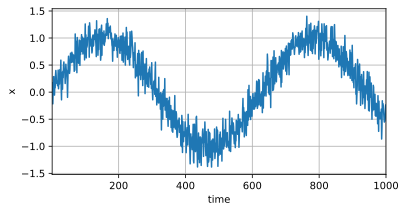

In [17]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

T = 1000  # 总共产生1000个点
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

In [18]:
tau = 4
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i: T - tau + i]
labels = x[tau:].reshape((-1, 1))

batch_size, n_train = 16, 600
# 只有前n_train个样本用于训练
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

In [19]:
# 初始化网络权重的函数
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

# 一个简单的多层感知机
def get_net():
    net = nn.Sequential(nn.Linear(4, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1))
    net.apply(init_weights)
    return net

# 平方损失。注意：MSELoss计算平方误差时不带系数1/2
loss = nn.MSELoss(reduction='none')

In [20]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 10, 0.01)

epoch 1, loss: 0.077554
epoch 2, loss: 0.049195
epoch 3, loss: 0.045555
epoch 4, loss: 0.045560
epoch 5, loss: 0.047004
epoch 6, loss: 0.045292
epoch 7, loss: 0.044649
epoch 8, loss: 0.045947
epoch 9, loss: 0.045338
epoch 10, loss: 0.049592


## 预测

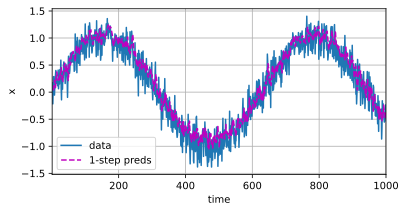

In [21]:
onestep_preds = net(features)
d2l.plot([time, time[tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy()], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 1000],
         figsize=(6, 3))

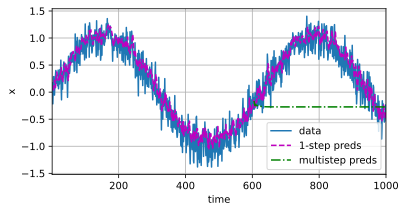

In [22]:
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(
        multistep_preds[i - tau:i].reshape((1, -1)))

d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(),
          multistep_preds[n_train + tau:].detach().numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

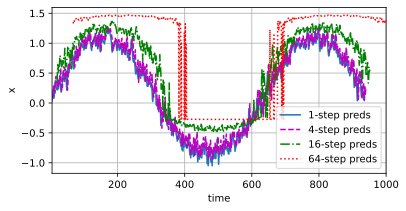

In [23]:
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# 列i（i<tau）是来自x的观测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]

# 列i（i>=tau）是来自（i-tau+1）步的预测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))

## 小结

- 内插法（在现有观测值之间进行估计）和外推法（对超出已知观测范围进行预测）在实践的难度上差别很大。因此，对于所拥有的序列数据，在训练时始终要尊重其时间顺序，即最好不要基于未来的数据进行训练。
- 序列模型的估计需要专门的统计工具，两种较流行的选择是自回归模型和隐变量自回归模型。
- 对于时间是向前推进的因果模型，正向估计通常比反向估计更容易。
- 对于直到时间步t的观测序列，其在时间步t+k的预测输出是“k步预测”。随着我们对预测时间k值的增加，会造成误差的快速累积和预测质量的极速下降。


## 练习

1. 改进本节实验中的模型。
    1. 是否包含了过去t个以上的观测结果？真实值需要是多少个？
    2. 如果没有噪音，需要多少个过去的观测结果？提示：把sin和cos写成微分方程。
    3. 可以在保持特征总数不变的情况下合并旧的观察结果吗？这能提高正确度吗？为什么？
    4. 改变神经网络架构并评估其性能。
2. 一位投资者想要找到一种好的证券来购买。他查看过去的回报，以决定哪一种可能是表现良好的。这一策略可能会出什么问题呢？
3. 时间是向前推进的因果模型在多大程度上适用于文本呢？
4. 举例说明什么时候可能需要隐变量自回归模型来捕捉数据的动力学模型。
